## Build a Digit Recognition Program

In this initiative, we aim to develop and implement a deep learning model designed to identify sequences of digits. The training will be conducted using synthetic datasets, which we will create by merging character images from the MNIST dataset.

For testing purposes, we will generate synthetic digit sequences, restricting them to a maximum of five digits. Our approach includes integrating five classifiers within the deep network architecture. Additionally, to manage sequences of varying lengths, we will introduce an extra 'blank' character.

The construction of this model will be executed using Keras, a Python-based deep learning API known for its simplicity and flexibility. 

In [48]:
#Imports
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D

from __future__ import print_function
from skimage.transform import resize
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
#Setting the random seed so that the results are reproducible. 
random.seed(101)

#Setting variables for MNIST image dimensions
mnist_image_height = 28
mnist_image_width = 28

In [50]:
#Import MNIST data from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)
Label for image: 5


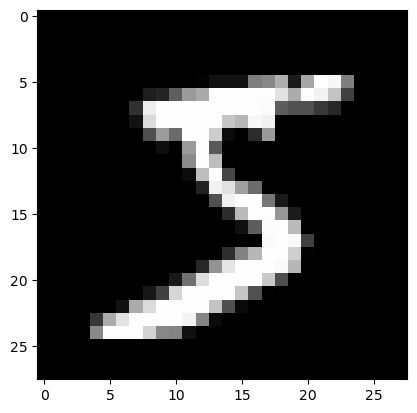

In [51]:
#Checking the downloaded data
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))


plt.figure()
plt.imshow(X_train[0], cmap='gray')

print("Label for image: {}".format(y_train[0]))

## Building synthetic data

The MNIST dataset is a classic starting point for those delving into deep learning. To elevate the complexity of our task, we're going to tackle the recognition of images that may contain between one and five digits. This challenge requires a redesign of our deep learning model's architecture, but first, we need to create a corresponding dataset.

Our strategy for crafting the synthetic training data involves randomly selecting up to five digits from the MNIST training set and then combining these into single images. Where fewer than five digits are chosen, we'll fill the gaps with 'blank' placeholders, ensuring each image represents a five-digit sequence. This method will not only enhance the diversity of our training set but also expand its volume, aiming for 60,000 examples.

In this image assembly process, we will simultaneously generate a five-element tuple label for each composite image. The numbers 0 through 9 will signify actual digits, while the number 10 will denote a 'blank' space.

This same technique will be applied to generate 10,000 synthetic test images, though we'll draw the individual digits from the MNIST test set instead.

Next, we'll develop a function to automate this process.

In [52]:
# Function to build synthetic data
def build_synth_data(data, labels, dataset_size):
    # Define synthetic image dimensions
    synth_img_height = 64
    synth_img_width = 64

    # Initialize synthetic data and labels
    synth_data = np.ndarray(shape=(dataset_size, synth_img_height, synth_img_width), dtype=np.float32)
    synth_labels = []

    # Loop to build the synthetic dataset
    for i in range(dataset_size):
        # Pick a random number of digits for the dataset
        num_digits = random.randint(1, 5)
        s_indices = [random.randint(0, len(data) - 1) for _ in range(num_digits)]

        # Stitch images together
        new_image = np.hstack([data[index] for index in s_indices])

        # Stitch the labels together
        new_label = [labels[index] for index in s_indices]

        # Loop to concatenate blank images and labels for shorter sequences
        for _ in range(5 - num_digits):
            new_image = np.hstack([new_image, np.zeros((mnist_image_height, mnist_image_width))])
            new_label.append(10)  # Indicates a blank space

        # Resize the stitched image
        new_image = resize(new_image, (synth_img_height, synth_img_width), anti_aliasing=True)
        new_image = (new_image * 255).astype(np.uint8)  # Scale back to 0-255 range and convert to uint8

        # Add the image and label to the synthetic dataset
        synth_data[i, :, :] = new_image
        synth_labels.append(tuple(new_label))

    # Return the synthetic dataset
    return synth_data, synth_labels

In [53]:
# Use the function to build the synthetic training dataset
X_synth_train, y_synth_train = build_synth_data(X_train, y_train, 60000)

In [54]:
#Building the test dataset
X_synth_test,y_synth_test = build_synth_data(X_test,y_test,10000)

(1, 4, 1, 9, 7)

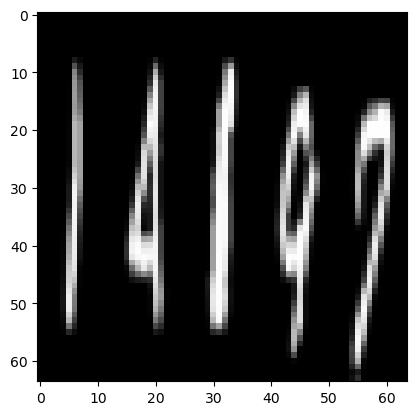

In [55]:
#checking a sample
plt.figure()
plt.imshow(X_synth_train[232], cmap='gray')

y_synth_train[232]

Looks like things work as we expect them to. Let's prepare the datset and labels so that keras can handle them.

## Preparatory Preprocessing

We'll transform the labels into one-hot encoded arrays to ensure compatibility with Keras. Since our deep learning model will incorporate five classifiers, each corresponding to a digit position in the image, we'll create five separate one-hot encoded arrays for each position.

In [56]:
def convert_labels(labels):
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes)) #5 for digits, 11 for possible classes  
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        #Using to_categorical from keras to OHE the labels in the image
        dig0_arr[index,:] = to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]


In [57]:
train_labels = convert_labels(y_synth_train)
test_labels = convert_labels(y_synth_test)

In [58]:
#Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(60000, 11)

In [59]:
to_categorical(y_synth_train[234], 11)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Preprocessing Images 

The function below will pre-process the images so that they can be handled by keras.

In [60]:
def prep_data_keras(img_data):
    
    #Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data),64,64,1)
    
    #Converting everything to floats
    img_data = img_data.astype('float32')
    
    #Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data

In [61]:
train_images = prep_data_keras(X_synth_train)
test_images = prep_data_keras(X_synth_test)

In [62]:
np.shape(train_images)

(60000, 64, 64, 1)

In [63]:
np.shape(test_images)

(10000, 64, 64, 1)

## Model Building

In [64]:
#Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

Our network will be built on a Convolutional Neural Network (CNN) framework. It will commence with a 2D Convolutional layer, post which ReLU activation functions will be applied subsequent to every convolutional layer.

Following the second convolution and its ReLU activation, we'll incorporate 2D Max Pooling and a dropout layer to fortify the model against overfitting. We will then utilize a flattening layer to prepare the data for the classification layers. These final layers will be dense, with each one comprising as many units as there are classes (in this case, 11), and will employ a softmax activation to output the probability for each class.

In [71]:
#Building the model

batch_size = 128
nb_classes = 11
epochs = 12  # updated from nb_epoch to epochs

#image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

#number of convolution filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

#defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

#Model architecture
cov = Conv2D(nb_filters, kernel_size, padding='same')(inputs)  # updated to Conv2D and padding
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters, kernel_size, padding='valid')(cov)  # updated to Conv2D
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)

#Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)

#Prediction layers
c0 = Dense(nb_classes, activation='softmax', name='c0')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

#Defining the model
model = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])

#Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy']
)


#Fitting the model
model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_images, test_labels))


Epoch 1/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 198ms/step - c0_accuracy: 0.4714 - dense_43_accuracy: 0.5522 - dense_44_accuracy: 0.6151 - dense_45_accuracy: 0.7207 - dense_46_accuracy: 0.8346 - loss: 5.4600 - val_c0_accuracy: 0.8784 - val_dense_43_accuracy: 0.8902 - val_dense_44_accuracy: 0.9173 - val_dense_45_accuracy: 0.9357 - val_dense_46_accuracy: 0.9648 - val_loss: 1.7251
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 204ms/step - c0_accuracy: 0.7222 - dense_43_accuracy: 0.7480 - dense_44_accuracy: 0.7789 - dense_45_accuracy: 0.8327 - dense_46_accuracy: 0.9031 - loss: 3.0415 - val_c0_accuracy: 0.9070 - val_dense_43_accuracy: 0.9147 - val_dense_44_accuracy: 0.9330 - val_dense_45_accuracy: 0.9499 - val_dense_46_accuracy: 0.9763 - val_loss: 1.3173
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 195ms/step - c0_accuracy: 0.7639 - dense_43_accuracy: 0.7864 - dense_44_accuracy: 0.8052 - dense_45_accuracy: 0.8525 - dense_46_accuracy: 0.9187 - loss: 2.5855 - val_c0_accuracy: 0.9179 - val_dense_43_a

In [72]:
predictions = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [73]:
np.shape(predictions)

(5, 10000, 11)

In [74]:
len(predictions[0])

10000

In [75]:
np.shape(test_labels)

(5, 10000, 11)

In [76]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [77]:
ind_acc,glob_acc = calculate_acc(predictions,test_labels)

In [78]:
print("The individual accuracy is {} %".format(ind_acc*100))
print("The sequence prediction accuracy is {} %".format(glob_acc*100))

The individual accuracy is 95.91 %
The sequence prediction accuracy is 81.39999999999999 %


In [79]:
#Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [9, 2, 1, 10, 10]
Predicted labels: [9, 2, 1, 10, 10]

Actual labels: [5, 0, 9, 9, 10]
Predicted labels: [5, 0, 9, 3, 10]

Actual labels: [4, 2, 10, 10, 10]
Predicted labels: [4, 2, 10, 10, 10]

Actual labels: [1, 1, 3, 10, 10]
Predicted labels: [1, 1, 3, 10, 10]

Actual labels: [7, 10, 10, 10, 10]
Predicted labels: [7, 10, 10, 10, 10]



The model demonstrated strong performance, accurately identifying single digits or blank spaces with a 95.91% success rate and correctly recognizing entire sequences 81.4% of the time.